# The Heavy-Tail Phenomenon in hSGD


In [3]:
# Required libraries are listed below. 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as scio
import math
from joblib import Parallel, delayed
from pandas import DataFrame
from time import time

from scipy.stats import t
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

from scipy import stats

In [4]:
"""datasets loading"""
def minist_dataset():
    print("loading MNIST dataset...")
    digits = datasets.load_digits()
    data = digits.data.astype("float")
    ##normalization I
    data = (data - data.min())/(data.max() - data.min())
    ##normalization II
    #row_norm = np.linalg.norm(data, axis=1, keepdims=True)
    #data = np.divide(data, row_norm)
    ##normalization III
    #data = normalize(data)
    print("samples:{}, dimension:{}".format(data.shape[0], data.shape[1]))
    
    """training data and test data"""
    #(trainX, testX, trainY, testY) = train_test_split(data, digits.target, test_size=0.2,random_state = 20,shuffle = True)
    
    label = LabelBinarizer().fit_transform(digits.target)
    
    #testY = LabelBinarizer().fit_transform(testY)
    
    return [data,label]

In [5]:
"""Turn the one-hot to one-dimension"""
def labeltransform(Y):
    y = np.zeros(len(Y))
    for i in range(0,len(Y)-1):
        y_1 = np.nonzero(Y[int(i),:])
        y[int(i)] = y_1[0]
        
    return 0.1 * y

In [6]:
"""dataset we need"""
[A, Y] = minist_dataset()

y = labeltransform(Y)

#print(np.shape(y))


print('----------------Before----------------')
print(Y[100])

print('\n\n----------------After----------------')
print(y[100])

# total number of data points 
n=A.shape[0]

# dimension
d=A.shape[1]



loading MNIST dataset...
samples:1797, dimension:64
----------------Before----------------
[0 0 0 0 1 0 0 0 0 0]


----------------After----------------
0.4


In [7]:
"""some parameters"""
# Number of iteratios
K = 10000
#regularization strength
delta = 0
#learning rate
eta = 0.1
#batchsize
b=1

In [8]:
 """tailindex by our result"""
#Singular value decomposition of training data A

P, E, QT = np.linalg.svd(A)


eigenvalue = E[0]
print(eigenvalue)
h_1 = 2 * n * b*(eigenvalue**2 + n*delta) / (eta * eigenvalue**4)+1

print(h_1)


[INFO] SGD interation...
        done in 0.006 minutes
137.069958552038
2.9129054736665863


In [9]:
 """lower bound"""
Lam = np.dot(E.T, E)
h_2 = 1 + 2 *b*n* (eigenvalue**2 + n*delta) / (eta * eigenvalue**4)+1 - Lam/eigenvalue**2
print(h_2)

2.476868300004667


In [10]:
(2 *b*n* (eigenvalue**2 + n*delta))/(eigenvalue**2 * Lam) # >learning rate

0.13320723925193698

In [11]:
# Loss function
def loss_fn(x,A,y,nsamp,delta):
    res = np.sum((np.dot(A,x) - y)**2)/(2*nsamp) + (delta/2)*np.dot(x,x)
    return res

In [12]:
def sgd_linreg(A,Y,n,d,K,eta,b,delta,compute_loss = False, plot_loss = False):
    
    loss_sgd = np.zeros(K)
    
    x_final = np.zeros(d)
    

    x_cur = 0.5 * np.random.randn(d)
    
    
    
    if(compute_loss is True):
        loss_sgd[0] = loss_fn(x_cur,A,Y,n,delta)

    for k in range(1,K):
        ix = np.random.permutation(n)
        S_k = ix[0:int(b)]
        A_k = A[S_k,:]
        y_k = Y[S_k]
        
        grad = np.dot(A_k.T, np.dot(A_k,x_cur)) - np.dot(A_k.T, y_k) - delta*x_cur
        grad = grad / b
        x_cur = x_cur - eta * grad

        if(compute_loss is True):
            loss_sgd[k] = loss_fn(x_cur,A,Y,n,delta)

    x_final = x_cur

    if(plot_loss is True):
        plt.figure()
        plt.semilogy(loss_sgd)
        #plt.plot(loss_sgd)
        
    return x_final

In [13]:
### main result

print("[INFO] SGD interation...")
t0 = time()

# Numer of repetitions

numRep = 1000


x_fn = np.zeros((d,numRep))
loss = np.zeros((K,numRep))


tmp_res = Parallel(n_jobs=10)(delayed(sgd_linreg)(A,y,n,d,K,eta,b,delta,compute_loss= True) for i in range(numRep))
tmp_res = np.array(tmp_res,dtype = object)
        

print("        done in %0.3f minutes" % ((time() - t0)/60))


[INFO] SGD interation...
        done in 5.795 minutes


In [14]:
Y = np.dot(QT, tmp_res.T)
Z = Y[0,:]
Z = Z - np.average(Z)
Z = Z.astype('float64')

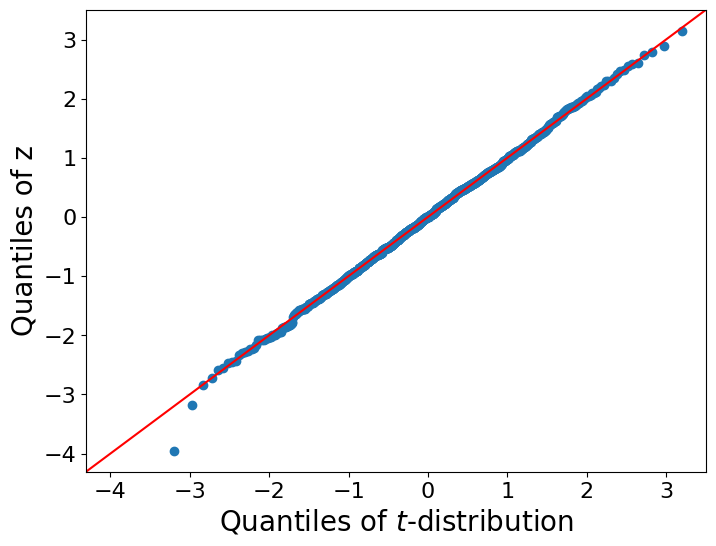

In [16]:
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(1,1)
sm.qqplot(Z, t,fit=True,line="45", ax = axs)

axs.set_xlabel('Quantiles of $t$-distribution', fontsize = 20)
axs.set_ylabel('Quantiles of z', fontsize = 20)
axs.tick_params(labelsize = 16)

plt.show()